In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_data(n):
    x1 = np.random.rand(n/4) * 10
    x2 = np.random.rand(3*n/4) * 40 + 20
    x = np.concatenate([x1, x2])
    y = np.sin(x)
    return x, y

/Library/Python/2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


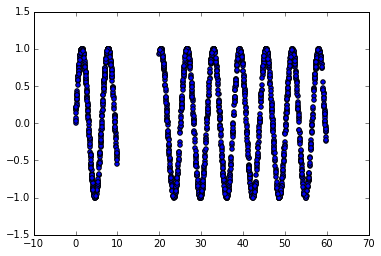

In [3]:
Ndata=2000
data_x, data_y = generate_data(Ndata)
Ndata = data_x.shape[0]
plt.scatter(data_x, data_y)
plt.show()

In [4]:
def linear(X, dout, name):
    with tf.variable_scope(name) as scope:
        _, dX = X.get_shape()
        W = tf.get_variable('W', shape=(dX, dout))
        tf.add_to_collection("decay_variables", W)
        b = tf.get_variable('b', shape=(dout))
    return tf.matmul(X, W)+b

def relu_layer(X, dout, name):
    return tf.nn.elu(linear(X, dout, name))

def ff_net(X, dout=1, layers=2, hidden_size=4):
    out = X
    for l in range(layers):
        out = linear(out, dout=hidden_size, name='ff_%d'%l)
        out2 = tf.cos(out)  # Give some inductive bias so that it fits properly
        out = tf.concat(1, [out, out2])
        #out = out2
    out = linear(out, dout=1, name='ff_final')
    return out


class FFnn(object):
    def __init__(self, name='ffnn', weight_decay=0):
        self.name = name
        with tf.variable_scope(name) as scope:
            self.x_t = tf.placeholder(tf.float32, [None, 1], name='x')
            self.y_t = tf.placeholder(tf.float32, [None, 1], name='y')
            
            self.pred = ff_net(self.x_t)
            
            self.loss = tf.reduce_mean(tf.square(self.pred-self.y_t))
            
            with tf.variable_scope('weights_norm'):
                weights_norm = tf.reduce_sum(
                  input_tensor = weight_decay*tf.pack(
                      [tf.nn.l2_loss(i) for i in tf.get_collection('decay_variables', scope=scope.name)]
                  ), name='weights_norm')
            if weight_decay>0:
                self.loss += weights_norm
            
            self.train_step = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(self.loss)
            
            
    
    def fit(self, x, y, n=2000, batch_size=32):
        print('beginning training %s' % self.name)
        N = x.shape[0]
        x = np.expand_dims(x, axis=1)
        y = np.expand_dims(y, axis=1)
        for i in range(n):
            bidx = np.random.randint(0, N, size=(batch_size,))
            _, loss = tf.get_default_session().run([self.train_step, self.loss], 
                                                   feed_dict={self.x_t: x[bidx], 
                                                              self.y_t: y[bidx]})
            if i % 200 == 0:
                print 'loss:', loss
    
    def predict(self, x):
        x = np.expand_dims(x, axis=1)
        return tf.get_default_session().run(self.pred, feed_dict={self.x_t: x})
            
            

In [5]:
tf.reset_default_graph()
sess = tf.Session()
nets = [FFnn(name='ffnn%d'%i) for i in range(5)]

with sess.as_default():
    sess.run(tf.initialize_all_variables())
    resamp_idx = np.random.randint(0, Ndata, size=(Ndata/2,))
    for net in nets:
        net.fit(data_x[resamp_idx], data_y[resamp_idx])

beginning training ffnn0
loss: 6.21063
loss: 0.149247
loss: 0.058164
loss: 0.0126944
loss: 0.0156342
loss: 0.00440895
loss: 0.00616992
loss: 0.000627714
loss: 0.00250493
loss: 0.000250216
beginning training ffnn1
loss: 146.1
loss: 0.38454
loss: 0.22747
loss: 0.12078
loss: 0.0768735
loss: 0.0299923
loss: 0.0849638
loss: 0.027935
loss: 0.0524591
loss: 0.0570468
beginning training ffnn2
loss: 157.669
loss: 0.473151
loss: 0.240758
loss: 0.205793
loss: 0.173896
loss: 0.187204
loss: 0.177809
loss: 0.189483
loss: 0.0597717
loss: 0.0413551
beginning training ffnn3
loss: 1663.3
loss: 0.419746
loss: 0.37537
loss: 0.21349
loss: 0.0803246
loss: 0.0569414
loss: 0.0623312
loss: 0.0438217
loss: 0.0464817
loss: 0.0349703
beginning training ffnn4
loss: 23.6615
loss: 0.292573
loss: 0.0801108
loss: 0.0203787
loss: 0.0027787
loss: 0.00078181
loss: 0.00045646
loss: 0.000204882
loss: 2.9728e-05
loss: 0.002256


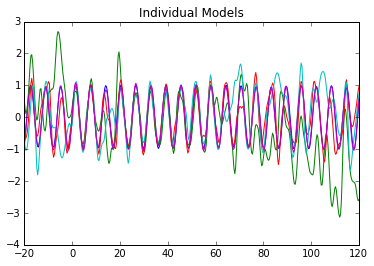

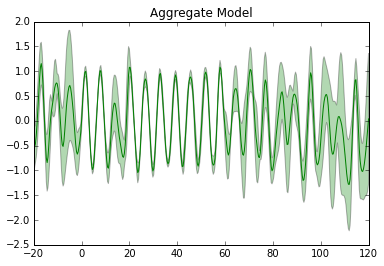

In [6]:
pred_x = np.linspace(-20, 120, num=400)
pred_ys = [None]*len(nets)
with sess.as_default():
    for i, net in enumerate(nets):
        pred_ys[i] = net.predict(pred_x)
pred_ys = np.array(pred_ys)[:,:,0]

mean_ys = np.mean(pred_ys, axis=0)
std_ys = np.std(pred_ys, axis=0)
for ys in (pred_ys):
    plt.plot(pred_x, ys)
plt.title('Individual Models')
plt.show()

plt.plot(pred_x, mean_ys, color='green')
plt.fill_between(pred_x, mean_ys-std_ys, mean_ys+std_ys ,alpha=0.3, facecolor='green')
plt.title('Aggregate Model')
plt.show()